In [ ]:
# Anomaly Detection in Vanadium Battery System
This notebook demonstrates a two-part approach for detecting anomalies in a Battery Storage System with an example for a Vanadium Redox Flow Battery (VRFB) system. The variables will have to be adjusted according to what is provided by the corresponding Battery Management System. The significant change of variables may impact the accuracy of the model.

### Objective:
- **Part 1**: Apply a **Gaussian Mixture Model (GMM)** to identify anomalies based on a threshold value.
- **Part 2**: Implement a **One-Class Support Vector Machine (SVM)** to handle scenarios where anomalous data is unavailable for training.

### Dataset Description:
The dataset includes various sensor readings from the battery system. The aim is to detect and flag abnormal readings using unsupervised machine learning techniques.

### Dependencies:
- `pandas` for data manipulation.
- `numpy` for numerical operations.
- `scikit-learn` for model implementation.
- `matplotlib` and `seaborn` for data visualization.

# 1st Part - GMM aplication

In [82]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Dataset_11var_treino.csv', sep=';')

# Select relevant features (11 variables from the data provider)
features = df[['DC Power Battery W', 'DC Voltage Battery V', 'Current DC Battery A', 'Voltage L1 V', 'Current L1 A', 'Temperature Eletrolite C', 'Avg Schneider Voltage L1 V', 'Avg Schneider Current L1 kA', 'Avg Schneider React Power L1 kVAr', 'Avg Schneider Power Factor L1', 'SOC' ]]
df.head()
df.describe()

,DC Power Battery W,DC Voltage Battery V,Current DC Battery A,Voltage L1 V,Current L1 A,Temperature Eletrolite C,Avg Schneider Voltage L1 V,Avg Schneider Current L1 kA,Avg Schneider React Power L1 kVAr,Avg Schneider Power Factor L1,SOC
count,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000,74992.000000
mean,740.352344,53.921738,12.157497,238.454995,1.557113,28.257974,239.311721,3.929748,0.648914,-0.415611,57.152870
std,1662.934632,3.411464,32.215857,1.412686,2.568581,1.873545,1.255047,0.930875,0.580030,0.060015,23.106728
min,-2805.000000,44.000000,-60.000000,233.000000,-4.000000,0.000000,233.093399,0.000000,-2.451885,-0.846869,0.000000
25%,1328.000000,52.000000,24.000000,238.000000,3.000000,27.000000,238.498516,4.067570,0.911320,-0.448980,39.000000
50%,1608.000000,54.000000,29.000000,238.000000,3.000000,28.000000,239.338440,4.360475,0.958247,-0.423150,61.000000
75%,1755.000000,56.000000,32.000000,239.000000,3.000000,29.000000,240.134697,4.482822,0.984599,-0.377555,77.000000
max,2236.000000,60.000000,44.000000,245.000000,4.000000,33.000000,246.808411,10.445412,1.187141,0.697964,91.000000


C:\Users\alexandre.lucas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\alexandre.lucas\AppData\Local\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


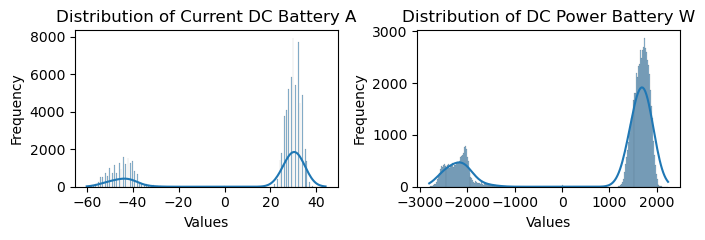

In [83]:
#We can take one or two variables as example and check if the data set is unimodal or multimodal to justify the use of a mixture model
# Assuming 'data' is your dataset
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7, 2.5))
sns.histplot(df['Current DC Battery A'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Current DC Battery A')
axes[0].set_xlabel('Values')
axes[0].set_ylabel('Frequency')

sns.histplot(df['DC Power Battery W'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of DC Power Battery W')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Implementation with the GMM - Train the model

In [84]:
# We will fit the data to n clusters. We do this because we aknowledge that there are multimodal regions not a unique (unimodal) as seen in the pot above
# Fit Gaussian Mixture Model to the initial normal behavior
n_components = 6  # You can adjust the number of components
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(features)

# Calculate the variance for each variable
variances = features.var(axis=0)

log_likelihoods = gmm.score_samples(features)
# Calculate mean and standard deviation of variances
mean_variance = variances.mean()
std_dev_variance = variances.std()



In [85]:
total_log_likelihood = np.sum(gmm.score_samples(features))

# Number of components (K) and dimensionality (D)
K = gmm.n_components
D = gmm.means_.shape[1]

# Calculate the number of parameters
num_parameters = (K - 1) + K * D + K * (D * (D + 1)) / 2

# Print the results
print("Total Log-Likelihood_GMM:", total_log_likelihood)
print("Number of Parameters:", num_parameters)

Total Log-Likelihood_GMM: -355806.3846919071
Number of Parameters: 467.0


In [86]:
print("Min value of log:likeihood is:",log_likelihoods.min())
print("Max value of log:likeihood is:",log_likelihoods.max())

Min value of log:likeihood is: -202.13042675621028
Max value of log:likeihood is: 0.3904895921812197


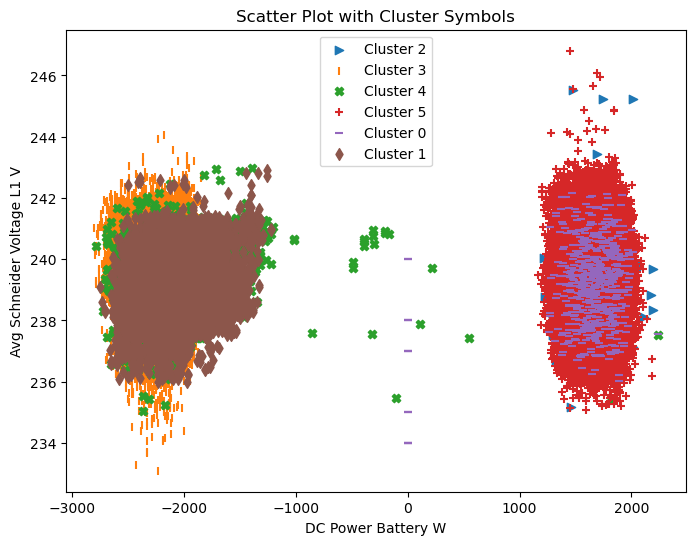

In [32]:
from pandas.plotting import scatter_matrix

labels = gmm.predict(features)
features_c = df[['DC Power Battery W', 'Avg Schneider Voltage L1 V']].copy()  # Use .copy()

# Add cluster labels to the DataFrame
features_c['Cluster'] = labels

# Define markers for each cluster
markers = ['_', 'd', '>', '|', 'X', '+']  # You can extend this list for more clusters

# Create scatter plot with markers representing clusters
plt.figure(figsize=(8, 6))

# Plot clusters 2 to 5 first
for cluster_label, marker in zip(range(2, 6), markers[2:]):
    cluster_data = features_c[features_c['Cluster'] == cluster_label]
    plt.scatter(cluster_data['DC Power Battery W'], cluster_data['Avg Schneider Voltage L1 V'], marker=marker, label=f'Cluster {cluster_label}')

# Plot clusters 0 and 1
for cluster_label, marker in zip([0, 1], markers[:2]):
    cluster_data = features_c[features_c['Cluster'] == cluster_label]
    plt.scatter(cluster_data['DC Power Battery W'], cluster_data['Avg Schneider Voltage L1 V'], marker=marker, label=f'Cluster {cluster_label}')

plt.xlabel('DC Power Battery W')
plt.ylabel('Avg Schneider Voltage L1 V')
plt.title('Scatter Plot with Cluster Symbols')
plt.legend()
plt.show()


In [87]:
#Indicators from the GMM. Select the number of clusters to minimize these indicators
aic = gmm.aic(features)
bic = gmm.bic(features)

print("AIC:", aic)
print("BIC:", bic)

AIC: 712546.7693838142
BIC: 716854.9082321301


# Generate the Likelihood values of the test dataset using GMM to test True positives

In [102]:
# Load the CSV file with multiple observations to test (We have two dataset 'test_observations.csv' and 'VRFB_Dataset.csv', Dataset_11var_treino.csv)
new_observations_df = pd.read_csv('test_observations.csv', sep=';') #Ideia de submeter o dataset de treino (sem anomalias) ao teste. Conseguiremos analisar quanto comportamento normal está a gaussiana total a capturar.

new_observations_df.head()
new_observations_df.describe()


,DC Power Battery W,DC Voltage Battery V,Current DC Battery A,Voltage L1 V,Current L1 A,Temperature Eletrolite C,Avg Schneider Voltage L1 V,Avg Schneider Current L1 kA,Avg Schneider React Power L1 kVAr,Avg Schneider Power Factor L1,SOC
count,130543.000000,130543.000000,130543.000000,130543.000000,130543.000000,130543.000000,130543.000000,130543.000000,130543.000000,130543.000000,130543.000000
mean,652.946477,56.589476,10.872938,237.995411,1.773232,26.164689,239.095303,5.722380,-0.251755,0.659294,50.033874
std,929.491824,5.326596,16.330394,1.450865,1.411991,2.484840,1.056154,3.049892,1.000433,0.952044,19.062222
min,-6260.000000,9.000000,-150.000000,230.000000,-12.000000,21.000000,231.587906,1.373392,-5.012218,-3.068624,0.000000
25%,142.000000,55.000000,3.000000,237.000000,1.000000,24.000000,238.747711,2.734172,-1.322295,-0.407562,40.000000
50%,334.000000,55.000000,6.000000,238.000000,2.000000,28.000000,239.306808,4.915861,0.161891,0.418180,52.000000
75%,923.000000,60.000000,15.000000,239.000000,2.000000,28.000000,239.306808,8.906170,0.480016,1.670387,68.000000
max,7217.000000,62.000000,120.000000,244.000000,12.000000,33.000000,244.844162,21.077139,3.028106,2.238821,71.000000


In [103]:
Linenbr_new_observations_df=new_observations_df.shape[0]
print(Linenbr_new_observations_df)

130543


In [104]:
# Select relevant features for the new observations
new_features = new_observations_df[['DC Power Battery W', 'DC Voltage Battery V', 'Current DC Battery A', 'Voltage L1 V', 'Current L1 A', 'Temperature Eletrolite C', 'Avg Schneider Voltage L1 V', 'Avg Schneider Current L1 kA', 'Avg Schneider React Power L1 kVAr', 'Avg Schneider Power Factor L1','SOC']]

# Calculate log-likelihoods for the new observations
log_likelihoods_test = gmm.score_samples(new_features)

new_observations_df['Log_Likelihood_test'] = log_likelihoods_test
variance_threshold=log_likelihoods.min() # CHANGE THIS VALUE according to the min/maximum of the train Dataset (depending on what we want to do). This is the maximum loglikelihood_test value
is_anomaly = log_likelihoods_test < variance_threshold

# Count the number of anomalies
anomaly_count = sum(is_anomaly)

# Print the count of anomalies
print("Number of anomalies detected:", anomaly_count)
print("% of anomalies detected:", anomaly_count/Linenbr_new_observations_df*100)
# Add a new column 'Is_Anomaly' to the new_observations_df
new_observations_df['Is_Anomaly'] = is_anomaly
# Save the updated DataFrame to a new CSV file containing the Log:likelihhod values
new_observations_df.to_csv('output_file.csv', index=False)

Number of anomalies detected: 85956
% of anomalies detected: 65.84497062270668


In [105]:
new_observations_df['Log_Likelihood_test'].describe()

count    130543.000000
mean       -655.019330
std         552.035052
min      -12392.256526
25%       -1309.678456
50%        -320.990272
75%        -165.174376
max          -7.274972
Name: Log_Likelihood_test, dtype: float64

In [106]:
df_out = pd.read_csv('output_file.csv')
df_out.head()

,Data,Hora,DC Power Battery W,DC Voltage Battery V,Current DC Battery A,Voltage L1 V,Current L1 A,Temperature Eletrolite C,Avg Schneider Voltage L1 V,Avg Schneider Current L1 kA,Avg Schneider React Power L1 kVAr,Avg Schneider Power Factor L1,SOC,Log_Likelihood_test,Is_Anomaly
0,16/05/2023,06:47:34,894,49,18,236,1,29,236.357330,5.121098,1.134354,0.364428,58,-206.626832,True
1,16/05/2023,06:47:37,3224,52,61,235,4,29,236.255920,6.336909,1.545501,-0.376334,58,-320.766695,True
2,16/05/2023,06:47:40,4553,54,84,235,4,29,236.328659,8.266622,1.917825,-0.390054,58,-579.043731,True
3,16/05/2023,06:47:43,4546,55,83,235,7,29,236.210449,8.319433,1.929512,-0.391419,58,-629.080315,True
4,16/05/2023,06:47:46,4546,55,83,234,7,29,236.233124,8.350428,1.926350,-0.393720,58,-642.534402,True


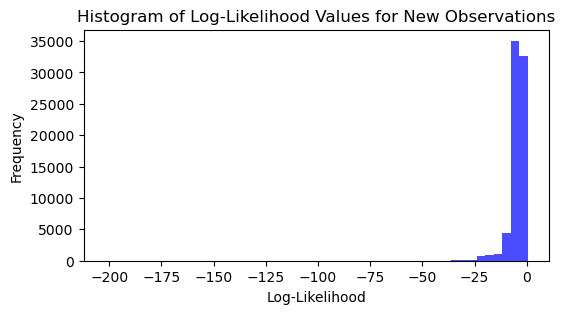

In [39]:
plt.figure(figsize=(6, 3))
plt.hist(log_likelihoods_test, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Log-Likelihood Values for New Observations')
plt.xlabel('Log-Likelihood')
plt.ylabel('Frequency')
plt.show()

In [96]:
df_out = pd.read_csv('output_file2.csv')
df_out.head()


,Data,Hora,DC Power Battery W,DC Voltage Battery V,Current DC Battery A,Voltage L1 V,Current L1 A,Temperature Eletrolite C,Avg Schneider Voltage L1 V,Avg Schneider Current L1 kA,Avg Schneider React Power L1 kVAr,Avg Schneider Power Factor L1,SOC,Log_Likelihood_test,Is_Anomaly
0,13/05/2023,06:14:37,0,57,0,240,0,0,240.0,0.0,0.0,0.0,0,-32.890681,False
1,13/05/2023,06:14:40,0,57,0,240,0,0,240.0,0.0,0.0,0.0,0,-32.890681,False
2,13/05/2023,06:14:43,0,57,0,240,0,0,240.0,0.0,0.0,0.0,0,-32.890681,False
3,13/05/2023,06:14:46,0,57,0,240,0,0,240.0,0.0,0.0,0.0,0,-32.890681,False
4,13/05/2023,06:14:49,0,54,0,235,0,0,235.0,0.0,0.0,0.0,0,-28.200466,False


In [97]:
numero_de_linhas = df_out.shape[0]
numero_de_linhas

74992

# Justifying why a GMM is better than a simple Gaussian fit

AIC_SG: 248481353399.07687
BIC_SG: 248481353408.302


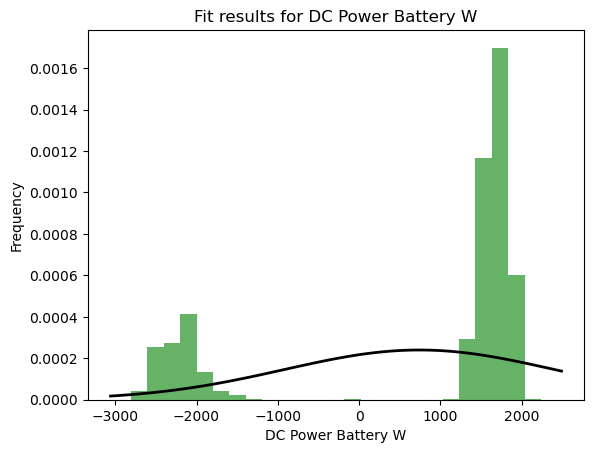

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

# Load the dataset
df1 = pd.read_csv('Dataset_11var_treino.csv', sep=';')

# Select relevant features (10 variables from the data provider)
features_SG = df1[['DC Power Battery W', 'DC Voltage Battery V', 'Current DC Battery A', 'Voltage L1 V', 'Current L1 A', 'Temperature Eletrolite C', 'Avg Schneider Voltage L1 V', 'Avg Schneider Current L1 kA', 'Avg Schneider React Power L1 kVAr', 'Avg Schneider Power Factor L1', 'SOC' ]]

# Fit a simple Gaussian model to the data
mu, std = norm.fit(features_SG['DC Power Battery W'])

# Plot the histogram of the data
plt.hist(features_SG['DC Power Battery W'], bins=25, density=True, alpha=0.6, color='g')

# Plot the Gaussian fit curve
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.title('Fit results for DC Power Battery W')
plt.xlabel('DC Power Battery W')
plt.ylabel('Frequency')

# Calculate AIC and BIC indicators
n_samples = len(features_SG['DC Power Battery W'])
aic_SG = -2 * norm.logpdf(features_SG['DC Power Battery W']).sum() + 2 * 1
bic_SG = -2 * norm.logpdf(features_SG['DC Power Battery W']).sum() + np.log(n_samples) * 1

#Indicators from the Simple Gaussinan (SG)
print(f'AIC_SG: {aic_SG}')
print(f'BIC_SG: {bic_SG}')

plt.show()


In [43]:
print("The lower the AIC or BIC value, the better the model is considered. Since the GMM AIC=", aic,"is lower than Simple Gaussinan AIC_SG", aic_SG, " we conclude that the GMM is a better application!")

The lower the AIC or BIC value, the better the model is considered. Since the GMM AIC= 712546.7693838142 is lower than Simple Gaussinan AIC_SG 248481353399.07687  we conclude that the GMM is a better application!


# Applying the model to the original training dataset to get the likelihood values and test false positives later on

In [108]:
# Load the CSV file with multiple observations to test
new_observations_df = pd.read_csv('Dataset_11var_treino.csv', sep=';') 
# Select relevant features for the new observations
new_features1 = new_observations_df[['DC Power Battery W', 'DC Voltage Battery V', 'Current DC Battery A', 'Voltage L1 V', 'Current L1 A', 'Temperature Eletrolite C', 'Avg Schneider Voltage L1 V', 'Avg Schneider Current L1 kA', 'Avg Schneider React Power L1 kVAr', 'Avg Schneider Power Factor L1', 'SOC']]

# Calculate log-likelihoods for the new observations
log_likelihoods_test = gmm.score_samples(new_features1)

new_observations_df['Log_Likelihood_test'] = log_likelihoods_test

# Save the updated DataFrame to a new CSV file
new_observations_df.to_csv('output_file1.csv', index=False)

# Plot the Components and the GMM Curve

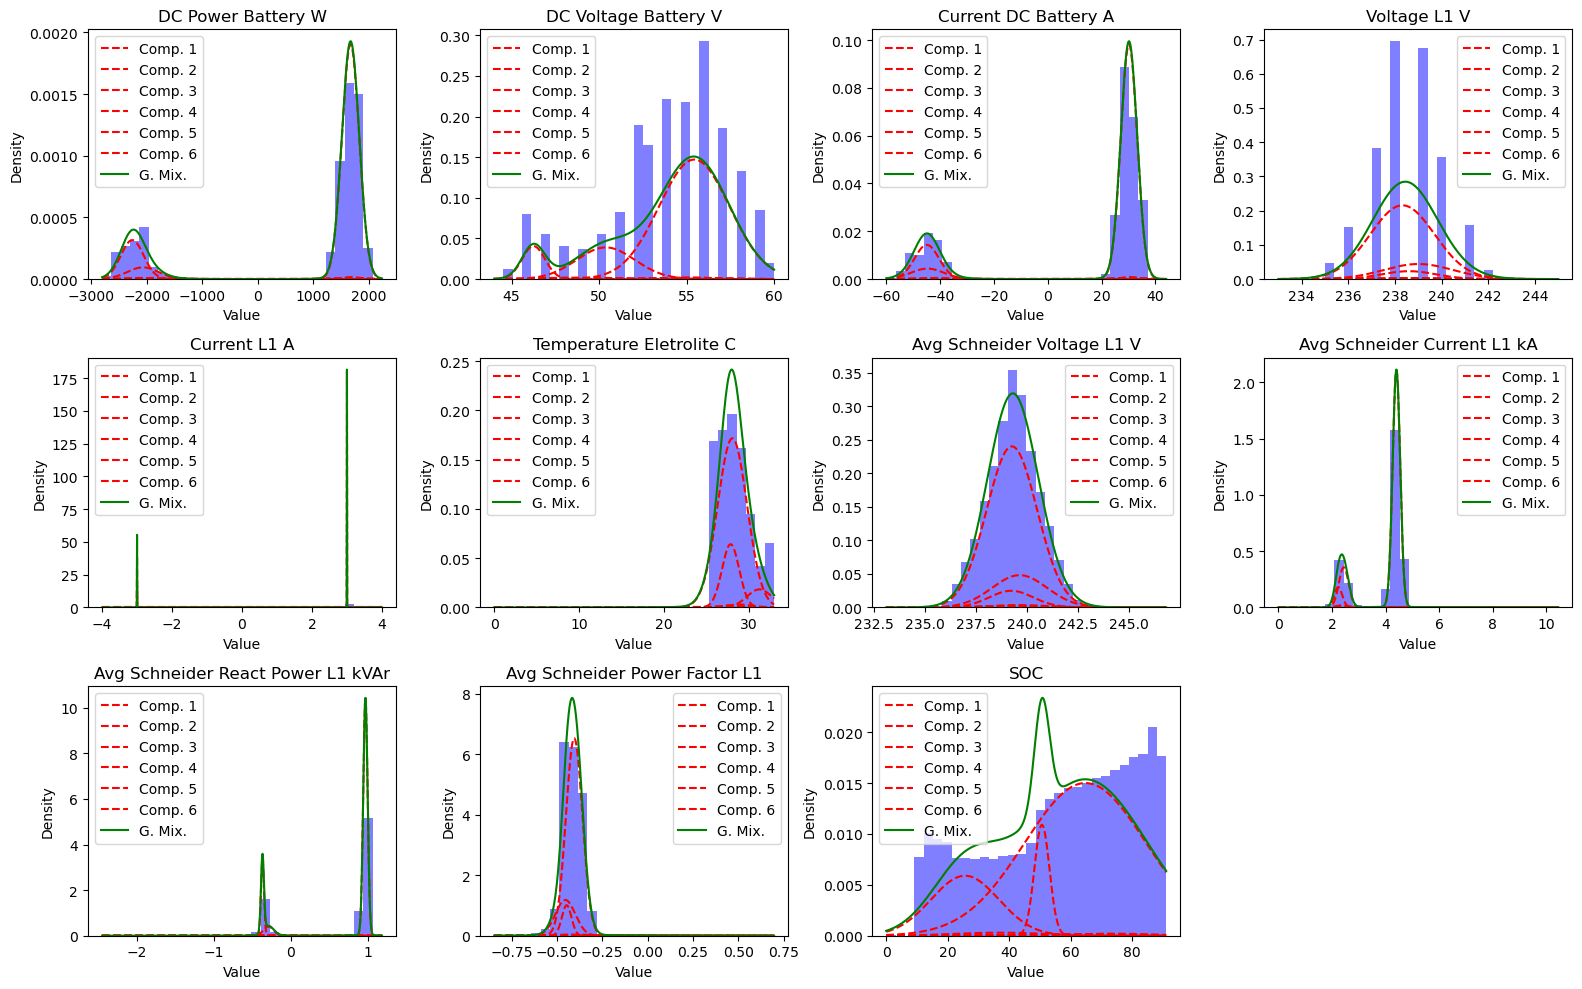

In [45]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from scipy.stats import norm

# Plot histogram of each feature with Gaussian mixture components
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features.columns):
    plt.subplot(3, 4, i+1)
    plt.hist(features[feature], bins=30, density=True, alpha=0.5, color='blue')

    # Plot Gaussian mixture components for this feature
    x = np.linspace(features[feature].min(), features[feature].max(), 1000)
    pdf_components = np.zeros_like(x)
    for j in range(n_components):
        weight = gmm.weights_[j]
        mean = gmm.means_[j, i]  # Extract mean for the specific feature
        std = np.sqrt(gmm.covariances_[j, i, i])  # Extract standard deviation for the specific feature
        pdf_components += norm.pdf(x, mean, std) * weight
        plt.plot(x, norm.pdf(x, mean, std) * weight, label=f'Comp. {j+1}', linestyle='--', color='red')
    
    # Plot resulting Gaussian mixture curve
    plt.plot(x, pdf_components, label='G. Mix.', color='green')
    
    plt.title(feature)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


# 2nd Part - ONE-Class SVM implementation

In [109]:
# We now take the log-likelihood values and train the model. 
# The log_likelihood values corresponding to normal observations are stores in output_file1 (from the training dataset)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Load the dataset generated by the training model of the GMM to train the OCSVM (normal data output_file1.csv)
df = pd.read_csv('output_file1.csv', sep=',', encoding='latin1')

# Extract the 'log-likelihood' variable
X_train = df['Log_Likelihood_test'].values.reshape(-1, 1)

# Train the one-class SVM model
ocsvm_model = OneClassSVM(nu=0.001, kernel="rbf", gamma=0.01)
ocsvm_model.fit(X_train)

OneClassSVM(gamma=0.01, nu=0.001)

# Fine Tune HyperParameters

In [47]:
#Run the cross validation in the first time to fine tune the hyperparameters
#We can tune the Kernel, the Gamma and the nu. here is an example for the nu parameter:
#param_grid = {'nu': [0.000001, 0001., 0.1, 0.5]}
#Perform Cross Validation to fine tune the nu parameter
#grid_search = GridSearchCV(ocsvm_model, param_grid, cv=5, scoring='accuracy')
#grid_search.fit(X_train)

# Get the best parameter value
#best_nu = grid_search.best_params_['nu']
#print("Best value of nu found:", best_nu)

# You can access other information such as best score and CV results as well
#print("Best cross-validation score:", grid_search.best_score_)
#print("Grid search results:", grid_search.cv_results_)

# Hyperparameter are:
#Kernel type (kernel),The choice of kernel function which can be Linear ('linear'), Radial basis function (RBF) ('rbf'), Polynomial ('poly'), Sigmoid ('sigmoid')
#nu relaxes or tightens the boundary - trade off between false positives and false negatives
# Kernel coefficient (gamma): This parameter is specific to the RBF, polynomial, and sigmoid kernels. It determines the influence of a single training example; low values imply a Gaussian-like function, and high values may lead to overfitting.

# Test The actual DataSets for abnormal observation and Export prediction results to CSV

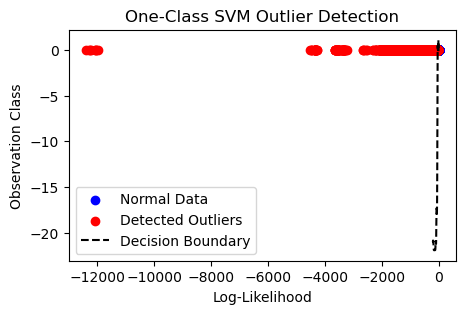

% of anomalies classified: 0.9863876270654114
Number of observations: 130543
Number of abnormal observations classified by the model: 128766 which is 98.64 %
Number of normal observations classified by the model: 1777 which is 1.36 %


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Load test data from CSV (use output1.csv to test the training dataset with normal observation, and output.csv or use output2.csv the new dataset)
test_data = pd.read_csv('output_file.csv', sep=',', encoding='latin1')

# Extract the 'log-likelihood' variable
X_test = test_data['Log_Likelihood_test'].values.reshape(-1, 1)

# Predict outliers on the test data
outlier_preds = ocsvm_model.predict(X_test)

# Extract hour and date columns
hour_column = test_data['Hora']
date_column = test_data['Data']

# Create a DataFrame with test data, hour, date, and predicted outliers
results_df = pd.DataFrame({'Date': date_column,
                           'Hour': hour_column,
                           'Log_Likelihood': X_test.flatten(),
                           'Outlier_Predictions': outlier_preds})

# Save the results to a CSV file
results_df.to_csv('OC_SVM_anomaly_results.csv', index=False)

# Calculate accuracy
true_labels = -1 * np.ones(len(X_test))  # Assuming all test data are abnormal
accuracy = accuracy_score(true_labels, outlier_preds)

# Plot the results
plt.figure(figsize=(5, 3))

# Plot normal data
plt.scatter(X_train, np.zeros_like(X_train), color='blue', label='Normal Data')

# Plot outliers detected by the model
plt.scatter(X_test[outlier_preds == -1], np.zeros_like(X_test[outlier_preds == -1]), color='red', label='Detected Outliers')

# Plot the decision boundary
xx = np.linspace(X_train.min(), X_train.max(), 500).reshape(-1, 1)
yy = np.zeros_like(xx)  # For 1D boundary plot
Z = ocsvm_model.decision_function(xx)
plt.plot(xx, Z, color='black', linestyle='dashed', label='Decision Boundary')

plt.xlabel('Log-Likelihood')
plt.ylabel('Observation Class')
plt.title('One-Class SVM Outlier Detection')
plt.legend()
plt.show()

# Print results
print("% of anomalies classified:", np.sum(outlier_preds == -1)/len(X_test))
print("Number of observations:", len(X_test))
print("Number of abnormal observations classified by the model:", np.sum(outlier_preds == -1),"which is",round(np.sum(outlier_preds == -1)/len(X_test)*100,2), "%")
print("Number of normal observations classified by the model:", np.sum(outlier_preds == 1),"which is", round(np.sum(outlier_preds == 1)/len(X_test)*100,2), "%")



# Apply the trigger ratio indicator - if more than 1 anomalies in 12 hours assessement for the OC-SVM results 

In [49]:
import pandas as pd
from datetime import datetime, timedelta

# Load the CSV file
df_ratio = pd.read_csv('OC_SVM_anomaly_results.csv')

# Parse the timestamp column to datetime
df_ratio['Hour'] = pd.to_datetime(df_ratio['Hour'], format='%H:%M:%S')
df_ratio

,Date,Hour,Log_Likelihood,Outlier_Predictions
0,10/04/2024,1900-01-01 10:10:11,49.229927,-1
1,10/04/2024,1900-01-01 10:10:14,49.229927,-1
2,10/04/2024,1900-01-01 10:10:17,49.229927,-1
3,10/04/2024,1900-01-01 10:10:21,49.229927,-1
4,10/04/2024,1900-01-01 10:10:24,49.229927,-1
...,...,...,...,...
451037,31/05/2024,1900-01-01 23:59:35,-4.422023,1
451038,31/05/2024,1900-01-01 23:59:41,-38.104112,-1
451039,31/05/2024,1900-01-01 23:59:46,-4.721738,1
451040,31/05/2024,1900-01-01 23:59:51,-6.373939,1


In [50]:
# Set the anomaly column to boolean
df_ratio['Outlier_Predictions'] = df_ratio['Outlier_Predictions'].map({1: False, -1: True})
# Set the time window for anomaly checking (12 hours)
df_ratio['Outlier_Predictions']

0          True
1          True
2          True
3          True
4          True
          ...  
451037    False
451038     True
451039    False
451040    False
451041    False
Name: Outlier_Predictions, Length: 451042, dtype: bool

In [51]:
alert_triggered = False
abnormal_observation_count = 0  # Counter for abnormal observations
time_window = timedelta(hours=12)

for index, row in df_ratio.iterrows():
    if row['Outlier_Predictions']:
        # Check if there are more than one anomaly in the past 12 hours
        recent_anomalies = df_ratio[(df_ratio['Hour'] > row['Hour'] - time_window) & (df_ratio['Hour'] <= row['Hour'])]
        count_recent_anomalies = recent_anomalies['Outlier_Predictions'].sum()

        if count_recent_anomalies > 3:
            alert_triggered = True
            abnormal_observation_count += 1

# Trigger alert message if needed
if alert_triggered:
    print("Anomaly ratios triggered within the past 12 hours:")
    print(f"Total abnormal observations: {abnormal_observation_count}")
    print("Please consider preventive maintenance")
else:
    print(f"The system is performing well, although: {np.sum(outlier_preds == -1)} abnormal observations were encontered")

KeyboardInterrupt: 